In [181]:
%pylab inline 

from nltk.corpus import stopwords
from nltk import PorterStemmer
import nltk
import ujson
import re
import time
import progressbar
import pandas as pd
import json
from nltk import word_tokenize
import numpy as np
import random
import string
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

nltk.download('stopwords') #download the latest stopwords

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gaura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\gaura\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


True

Original parsing code

In [173]:
import pandas as pd
import gzip
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)
        
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# change this
df = getDF('reviews_Office_Products_5.json.gz')

Custom parsing code

In [176]:

category_map = {
   # "Amazon_Instant_Video" : 0,
   # "Apps_for_Android" : 1,
   # "Automotive" : 2,
   # "Baby" : 3,
   # "Beauty" : 4,
   # "Books" : 5,
#     "CDs_and_Vinyl" : 6,
#     "Cell_Phones_and_Accessories" : 7,
#     "Clothing_Shoes_and_Jewelry" : 8,
#     "Digital_Music" : 9,
#    "Electronics" : 10
#     "Grocery_and_Gourmet_Food" : 11,
#     "Health_and_Personal_Care" : 12,
#     "Home_and_Kitchen" : 13,
#     "Kindle_Store" : 14,
#     "Movies_and_TV" : 15,
#     "Musical_Instruments" : 16,
     "Office_Products" : 17
#     "Patio_Lawn_and_Garden" : 18,
#     "Pet_Supplies" : 19,
#     "Sports_and_Outdoors" : 20,
#     "Tools_and_Home_Improvement" : 21,
#     "Toys_and_Games" : 22,
#     "Video_Games" : 23
}

col_names = ["reviewer_id", "asin", "summary","review_text", "overall", "category", "total_votes","upvotes","score",
             "good", "bad"]

def read_dataset():
    data =[]
    for category in category_map:
        fn = category + "_"+"5" + ".json"
        print("Reading category", category)
        with open(fn) as f:
            for line in f:
                d = json.loads(line)
                pf, tf = d["helpful"]
                if tf > 0 and len(d["reviewText"].split()) > 10:
                    score = int(pf) / int(tf)
                    row = [d["reviewerID"], 
                           d["asin"], 
                           d["summary"],
                           d["reviewText"],
                           d["overall"],
                           category_map[category],
                           int(tf),
                           int(pf),
                           (score),
                           int(score >= 0.80),
                           int(score <= 0.20)]
                    data.append(row)
                    
    return pd.DataFrame(data, columns=col_names)

df = read_dataset()

Reading category Office_Products


In [179]:
df.head(2).review_text.values

array([ "I bought my first HP12C in about 1984 or so, and it served me faithfully until 2002 when I lost it while travelling.  I searched for another one to replace it, but found one difficult to come by in my area.  So, I decided to buy up and purchased an HP 49G.  What a mistake!  I know that many people view the HP 49G (now 49G+) as the flagship of the HP line, but for me that was a disaster.The 49G may be powerful, but using it is extremely counterintuitive...and the manual was sketchy at best.  The 12C, on the other hand, does what I need in a way that makes good sense to me.If you are looking for a solid, reliable calculator, the HP12C may be for you.  It's programmable.  It does basic statistics well, and many business applications too.  The manual makes sense; you will be up and running in short order.I'm ready to set my 49G aside and move back to my old friend.  I didn't even have to replace the batteries in well over a decade of use!HP 12C, I'm coming home!",
       'WHY THIS

Histogram of word counts

In [42]:
def word_count(text):
    return len([x for x in text.split()])

Wall time: 0 ns


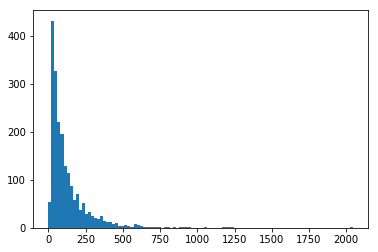

In [92]:
%time
cnt = map(word_count, df.query('score == 1').review_text.values)
hist(list(cnt), bins = 100);

In [94]:
pd.crosstab(df.score.values, columns = 'CT')

col_0,CT
row_0,
0,1425
1,2040


Negative filtering logic: total upvotes less than half of the total votes

In [200]:
df_negative = df[(df.total_votes - df.upvotes)/df.total_votes > 0.5]

In [241]:
stemmer = PorterStemmer()
eng_stopwords =  stopwords.words('english')

RE_PREPROCESS = r'\W+|\d+'  
#get rid of punctuation and make everything lowercase
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', review).lower() for review in df_negative.review_text.values] )

vectorizer = CountVectorizer(analyzer = "word",
                            tokenizer = lambda x: [stemmer.stem(i) for i in x.split()], 
                            ngram_range = (0, 3),
                            stop_words = eng_stopwords,
                            strip_accents = "unicode",
                            min_df = 0.05,
                            max_df = 0.95)

In [242]:
%%time
bag_of_words = vectorizer.fit_transform( processed_corpus )
features = vectorizer.get_feature_names()

Wall time: 15.2 s


In [243]:
transformer = TfidfTransformer(norm = None,
                               sublinear_tf = True)

In [244]:
%%time
tfidf = transformer.fit_transform(bag_of_words)

Wall time: 5.01 ms


In [247]:
np_bag_of_words = tfidf.toarray()
word_count = np.sum(tfidf,axis=0)
np_word_count = np.asarray(word_count).ravel()
dict_word_counts = dict( zip(features, np_word_count) )
orddict_word_counts = OrderedDict( 
                                sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
orddict_word_counts # helpful